In [18]:
# Importando as bibliotecas necessárias
import pandas as pd
import os
import kagglehub
import shutil
import requests
import gzip
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [19]:
DATA_FOLTER = '../data/'
# 1. Carregar os Dados
df = pd.read_csv(DATA_FOLTER + 'filmes_series_imdb.csv')

# --- LIMPEZA E PREPARAÇÃO ---

# Remover o '\n' e converter tempo para número
df['run_time_minutes'] = df['run_time_minutes'].astype(str).str.replace(r'\n', '', regex=True).str.strip()
df['run_time_minutes'] = pd.to_numeric(df['run_time_minutes'], errors='coerce')

# Remover linhas onde não temos a nota (o alvo)
df = df.dropna(subset=['imdb_rating_concatenada'])

# Preencher valores numéricos faltantes com a mediana
cols_numericas = ['release_year', 'run_time_minutes']
imputer = SimpleImputer(strategy='median')
df[cols_numericas] = imputer.fit_transform(df[cols_numericas])

# --- ENGENHARIA DE FEATURES (Transformar texto em número) ---

# 1. Gêneros (Transforma "Action, Drama" em colunas Genre_Action=1, Genre_Drama=1)
# Preenche nulos com 'Unknown' para não dar erro
df['genres_processed'] = df['genres_processed'].fillna('Unknown')
genres_dummies = df['genres_processed'].str.get_dummies(sep=', ').add_prefix('Genre_')
df = pd.concat([df, genres_dummies], axis=1)

# 2. Plataforma e Tipo (Transforma "Netflix" em streaming_Netflix=1)
df = pd.get_dummies(df, columns=['type', 'streaming'], drop_first=True)

# --- DEFINIÇÃO DE X (Features) e y (Alvo) ---

# Selecionamos: Ano, Duração + Todas as colunas Dummies que criamos (Gênero, Tipo, Streaming)
colunas_features = ['release_year', 'run_time_minutes'] + \
                   [c for c in df.columns if c.startswith('Genre_')] + \
                   [c for c in df.columns if c.startswith('type_')] + \
                   [c for c in df.columns if c.startswith('streaming_')]

X = df[colunas_features]
y = df['imdb_rating_concatenada']

# --- TREINO E AVALIAÇÃO ---

# Dividir em Treino (80%) e Teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e Treinar o Modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Fazer Previsões
previsoes = modelo.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, previsoes))
r2 = r2_score(y_test, previsoes)

print(f"--- Resultados do Modelo ---")
print(f"RMSE (Erro Médio): {rmse:.2f}")
print(f"R² (Explicação dos Dados): {r2:.2f}")

# (Opcional) Ver quais gêneros aumentam mais a nota
impactos = pd.DataFrame({'Feature': X.columns, 'Coeficiente': modelo.coef_})
print("\nTop 5 Fatores que AUMENTAM a nota:")
print(impactos.sort_values(by='Coeficiente', ascending=False).head(5))

# ... (todo o seu código anterior de treino do modelo) ...

# --- CRIANDO A "TABELA VERDADE" (COMPARATIVA) ---

# Criamos um DataFrame novo juntando o Título (para saber qual filme é), a Nota Real e a Prevista
tabela_comparativa = pd.DataFrame({
    'Título': df.loc[y_test.index, 'title'],  # Pega o título original usando o índice de teste
    'Nota Real': y_test,
    'Nota Prevista': previsoes.round(1),         # Arredonda para ficar legível
    'Diferença (Erro)': (y_test - previsoes).round(1)
})

# Adiciona uma coluna de Erro Absoluto (para ordenar sem se preocupar com sinal negativo)
tabela_comparativa['Erro Absoluto'] = tabela_comparativa['Diferença (Erro)'].abs()

# --- VISUALIZANDO OS RESULTADOS ---

print("--- TOP 5 ACERTOS (Onde o modelo foi perfeito) ---")
# Ordena pelo menor erro absoluto
print(tabela_comparativa.sort_values(by='Erro Absoluto').head(5))

print("\n--- TOP 5 ERROS (Onde o modelo mais errou) ---")
# Ordena pelo maior erro absoluto
print(tabela_comparativa.sort_values(by='Erro Absoluto', ascending=False).head(5))



--- Resultados do Modelo ---
RMSE (Erro Médio): 1.04
R² (Explicação dos Dados): 0.29

Top 5 Fatores que AUMENTAM a nota:
                 Feature  Coeficiente
317         type_TV Show     0.850343
232    Genre_Documentary     0.201818
231    Genre_Documentary     0.201818
148  Genre_Documentary.1     0.201818
43     Genre_Documentary     0.201818
--- TOP 5 ACERTOS (Onde o modelo foi perfeito) ---
                            Título  Nota Real  Nota Prevista  \
9626           Love aaj Kal Porshu        6.0            6.0   
6887   America: The Motion Picture        5.6            5.6   
562                     Gadget Man        7.5            7.5   
14191                   Cyberchase        6.9            6.9   
6444           A Mile in His Shoes        6.1            6.1   

       Diferença (Erro)  Erro Absoluto  
9626                0.0            0.0  
6887               -0.0            0.0  
562                -0.0            0.0  
14191              -0.0            0.0  
6444      

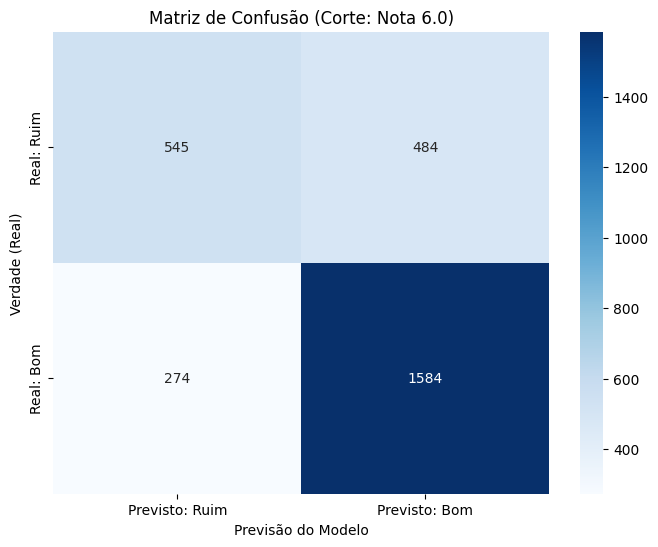

Relatório de Classificação:
              precision    recall  f1-score   support

        Ruim       0.67      0.53      0.59      1029
         Bom       0.77      0.85      0.81      1858

    accuracy                           0.74      2887
   macro avg       0.72      0.69      0.70      2887
weighted avg       0.73      0.74      0.73      2887



In [ ]:
DATA_FOLTER = '../data/'

# 1. Carregar os Dados
df = pd.read_csv(DATA_FOLTER + 'filmes_series_imdb.csv')

df['run_time_minutes'] = df['run_time_minutes'].astype(str).str.replace(r'\n', '', regex=True).str.strip()
df['run_time_minutes'] = pd.to_numeric(df['run_time_minutes'], errors='coerce')
df = df.dropna(subset=['imdb_rating_concatenada'])

cols_numericas = ['release_year', 'run_time_minutes']
imputer = SimpleImputer(strategy='median')
df[cols_numericas] = imputer.fit_transform(df[cols_numericas])

# Features (Gênero, etc)
df['genres_processed'] = df['genres_processed'].fillna('Unknown')
genres_dummies = df['genres_processed'].str.get_dummies(sep=', ').add_prefix('Genre_')
df = pd.concat([df, genres_dummies], axis=1)
df = pd.get_dummies(df, columns=['type', 'streaming'], drop_first=True)

# --- A MUDANÇA MÁGICA: CRIAR CLASSES ---
# Para ter matriz de confusão, precisamos de categorias.
# Vamos definir: Filme Bom = Nota >= 6.0
threshold = 6.0
df['categoria'] = np.where(df['imdb_rating_concatenada'] >= threshold, 1, 0) # 1=Bom, 0=Ruim

# Definir X e y
colunas_features = ['release_year', 'run_time_minutes'] + \
                   [c for c in df.columns if c.startswith('Genre_')] + \
                   [c for c in df.columns if c.startswith('type_')] + \
                   [c for c in df.columns if c.startswith('streaming_')]

X = df[colunas_features]
y = df['categoria'] # Agora prevemos a CATEGORIA, não a nota exata

# Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo: Regressão LOGÍSTICA (Classificação)
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# --- GERAR A MATRIZ DE CONFUSÃO ---
cm = confusion_matrix(y_test, y_pred)

# Plotar Bonito
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto: Ruim', 'Previsto: Bom'],
            yticklabels=['Real: Ruim', 'Real: Bom'])
plt.title(f'Matriz de Confusão (Corte: Nota {threshold})')
plt.ylabel('Verdade (Real)')
plt.xlabel('Previsão do Modelo')
plt.show() # Salva ou mostra o gráfico

# Métricas de Classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Ruim', 'Bom']))